# Detecting Gender Bias in text using Word Embedding

--> Word embeddings are vector representation of words that can be used as inputs to other tasks and ML models. In their paper https://arxiv.org/pdf/1607.06520.pdf, the authors have a list of occupations they found to have an extreme gender bias, either male or female. They found these by comparing the similarty of the vector of each occupation with the vectors for the words "he" and "she". In this case "similarity" was quantified as the inner product of two sets of vectors.

--> Word2Vec and GloVe are pre-trained embeddings.the vectors that these authors used were trained using word2vec rather than GloVe. While Word2Vec is trained on 3 million word corpus of Google News, pre-trained GloVe embeddings are trained on the Wikipedia 2014 + Gigaword 5th Edition corpora.

Some extreme 'she' occupations would be: librarian, socialite, hairdresser, nanny, bookkeeper, stylist, housekeeper etc.
Some extreme 'he' occupations would be: architect, financier, warrior, broadcaster, magician, fighter pilot, boss etc.

Considering the dissimilarities between the two embedding sets of extreme 'he' job and 'she' jobs, is it valid to assume that the correlations between the words "he" and "she" and the listed occupations still hold?

In [6]:
# import libraries which we will use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# read the text file
# This dataset contains English word vectors pre-trained on the combined Wikipedia 2014 + Gigaword 5th Edition corpora (6B tokens, 400K vocab). This dataset contains 50-dimensional pre trained word vectors, sorted by frequency.a
embeddings = pd.read_csv("glove.6B.50d.txt",sep=" ", header=None, quoting=3, index_col=0)
embeddings.index.name = 'wording'
embeddings.shape

(400000, 50)

In [10]:
embeddings.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
wording,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.12170,0.34527,-0.044457,-0.49688,-0.17862,-0.00066,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.44251,0.187850,0.002785,-0.184110,-0.115140,-0.78581
",",0.013441,0.236820,-0.16899,0.40951,0.63812,0.477090,-0.42852,-0.55641,-0.36400,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.22786,0.360340,-0.378180,-0.566570,0.044691,0.30392
.,0.151640,0.301770,-0.16763,0.17684,0.31719,0.339730,-0.43478,-0.31086,-0.44999,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.13931,0.223140,-0.080803,-0.356520,0.016413,0.10216
of,0.708530,0.570880,-0.47160,0.18048,0.54449,0.726030,0.18157,-0.52393,0.10381,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.38988,0.229020,-0.216170,-0.225620,-0.093918,-0.80375
to,0.680470,-0.039263,0.30186,-0.17792,0.42962,0.032246,-0.41376,0.13228,-0.29847,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.19722,0.082279,-0.094340,-0.073297,-0.064699,-0.26044


### Now we will add in our list of occputations & write a function that will allow us to quickly get the similarity measure between the a set of word vectors & the vectors of two seperate words.

In [11]:
# get the vectors for "he" and "she"
he = np.array(embeddings.loc['he'][1:])
she = np.array(embeddings.loc['she'][1:])

C:\Users\gupta\AppData\Local\Temp\ipykernel_9880\2339466480.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  he = np.array(embeddings.loc['he'][1:])
C:\Users\gupta\AppData\Local\Temp\ipykernel_9880\2339466480.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  she = np.array(embeddings.loc['she'][1:])


In [12]:

# Some occupations are two-word phrases, but since these vectors are for single words, I picked one word for each two-word phrase
heOccupations = ["maestro", "skipper", "protege", "philosopher", "captain",
                 "architect", "financier", "warrior", "broadcaster", "magician",
                 "pilot", "boss"]
sheOccupations = ["homemaker", "nurse", "receptionist", "librarian", "socialite",
                 "hairdresser", "nanny", "bookkeeper", "stylist", "housekeeper",
                 "designer", "counselor"]

In [18]:
import inspect

# function to get the similarity between words 
def wordEmbeddingSimilarity(words, he, she, embeddings):
    # empty dataframe to put our embeddings subset in
    smallerEmbeddingsList = pd.DataFrame()
    
    # get the vector for each word of interest
    for word in words:
        new = embeddings.loc[word].to_frame().transpose()
        smallerEmbeddingsList = pd.concat([smallerEmbeddingsList, new], ignore_index=True)
    
    # empty dataframe to put our similarity measures in
    similarity = pd.DataFrame(columns=["he", "she", "word", "bias"])

    #    function for getting the bias name.
    def get_list_name(heOccupations, sheOccupations, input_value):
        list1_name = [k for k, v in locals().items() if v == heOccupations][0]
        list2_name = [k for k, v in locals().items() if v == sheOccupations][0]

        if input_value in heOccupations:
            return "heOccupations"
        elif input_value in sheOccupations:
            return "sheOccupations"
        else:
            return None
    
    # get similarity measures for the list of words w/both "he" and "she"
    for i in range(smallerEmbeddingsList.shape[0]):
        word = smallerEmbeddingsList.loc[i, 1]
        wordVec = np.array(smallerEmbeddingsList.loc[i][1:])
        sheSim = np.dot(wordVec, she)
        heSim = np.dot(wordVec, he)
        #similarity = similarity.append(pd.DataFrame({"he": heSim, "she": sheSim, "word": word, "bias": "he-she"}))
        similarity = pd.concat([similarity, pd.DataFrame({'he': [heSim], 'she': [sheSim], 'word': [words[i]], 'bias': [get_list_name(heOccupations,sheOccupations, words[i])]})])
       
    
    # return our similarity metrics
    return similarity

# get similarity measures for "he" occupations
heOccupationsSimilarity = wordEmbeddingSimilarity(heOccupations, he, she, embeddings)

# get similarity measures for "she" occupations
sheOccupationsSimilarity = wordEmbeddingSimilarity(sheOccupations, he, she, embeddings)

# combine dataframes
similarityMeasures = pd.concat([heOccupationsSimilarity, sheOccupationsSimilarity])
similarityMeasures= pd.DataFrame(similarityMeasures)
print(similarityMeasures.head(20))

C:\Users\gupta\AppData\Local\Temp\ipykernel_9880\1415368854.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  wordVec = np.array(smallerEmbeddingsList.loc[i][1:])
C:\Users\gupta\AppData\Local\Temp\ipykernel_9880\1415368854.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  wordVec = np.array(smallerEmbeddingsList.loc[i][1:])
C:\Users\gupta\AppData\Local\Temp\ipykernel_9880\1415368854.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecate

          he        she          word            bias
0   5.063854   3.202725       maestro   heOccupations
0   9.933387   5.656273       skipper   heOccupations
0   4.793510   3.736121       protege   heOccupations
0   8.586571   6.391808   philosopher   heOccupations
0  17.709099  13.038669       captain   heOccupations
0  11.183532   7.856621     architect   heOccupations
0   4.955236   1.424195     financier   heOccupations
0   8.544932   8.222232       warrior   heOccupations
0   8.644283   7.467735   broadcaster   heOccupations
0   6.626371   6.929187      magician   heOccupations
0  13.850102  14.152126         pilot   heOccupations
0  15.226570  11.832751          boss   heOccupations
0   4.835917   9.010248     homemaker  sheOccupations
0  13.028105  17.947101         nurse  sheOccupations
0   3.980630   7.687030  receptionist  sheOccupations
0   8.511658   9.981073     librarian  sheOccupations
0   1.124831   6.359936     socialite  sheOccupations
0   3.876794   7.707987   ha

C:\Users\gupta\AppData\Local\Temp\ipykernel_9880\1415368854.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  wordVec = np.array(smallerEmbeddingsList.loc[i][1:])
C:\Users\gupta\AppData\Local\Temp\ipykernel_9880\1415368854.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  wordVec = np.array(smallerEmbeddingsList.loc[i][1:])
C:\Users\gupta\AppData\Local\Temp\ipykernel_9880\1415368854.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecate

## Visualize these similarities & see if our reuslts are similar to the authors' findings.

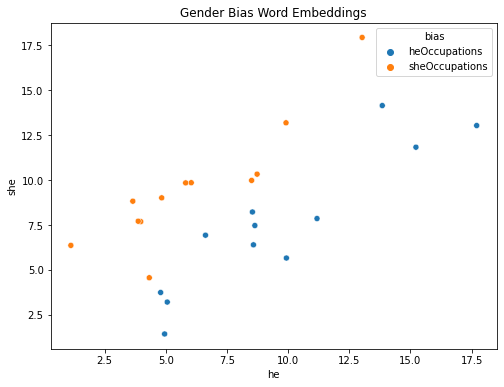

In [22]:
similarityMeasures = pd.DataFrame(similarityMeasures)
similarityMeasures['he'] = pd.to_numeric(similarityMeasures['he'])
similarityMeasures['she'] = pd.to_numeric(similarityMeasures['she'])

similarityMeasures['bias'] = similarityMeasures['bias'].astype('category')

plt.figure(figsize=(8, 6))
sns.scatterplot(x='he', y='she', hue='bias', data=similarityMeasures)

# add title and labels
plt.title('Gender Bias Word Embeddings')
plt.xlabel('he')
plt.ylabel('she')

plt.show()


In [23]:
# From the above graph, we can clearly see the seperation between these two classes of words. Let's look at it another way.

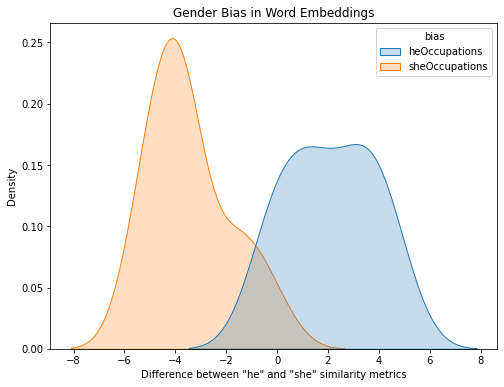

In [27]:
# lets plot the difference of "he" and "she" similarity metrics. Hhigher = more "he" bias, Lower = more "she" bias

# create a new column for the difference between "he" and "she" similarity metrics
similarityMeasures['difference'] = similarityMeasures['he'] - similarityMeasures['she']
plt.figure(figsize=(8, 6))
# plot the density of the difference by bias
sns.kdeplot(data=similarityMeasures, x='difference', hue='bias', fill=True, common_norm=False)

# add labels and a title
plt.xlabel('Difference between "he" and "she" similarity metrics')
plt.ylabel('Density')
plt.title('Gender Bias in Word Embeddings')
plt.show()

### Based on the analysis, it seems that the biases that were discovered in the Authors' study for word2vec vectors trained on the Google News corpus are also present in the GloVe vectors trained on a corpus that consists of the Wikipedia and Gigaword corpora combined. This indicates that the earlier findings were not due to specific factors such as the use of news stories or the word2vec algorithm. Hence the bias is present.